# A/B testing: A step-by-step guide in Python

Рассмотрим процесс анализа A / B-теста, от формулирования гипотезы, ее проверки и, наконец, интерпретации результатов. Для наших данных мы будем использовать <a href='https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv'>набор данных из Kaggle</a> который содержит результаты A/B-теста двух разных дизайнов страницы веб-сайта (old_page и new_page). Вот что мы сделаем:

1. [Дизайн эксперимента](#1.-Дизайн-эксперимента)
2. [Сбор и подготовка данных](#2.-Сбор-и-подготовка-данных)
3. [Визуализация результатов](#3.-Визуализация-результатов)
4. [Тестирование гипотезы](#4.-Тестирование-гипотезы)
5. [Выводы](#5.-Выводы)

Чтобы сделать это немного более реалистичным, вот потенциальный **сценарий** для нашего исследования:

> Представьте, что вы работаете в группе разработчиков **предприятия электронной коммерции в Интернете**. Дизайнер UX очень усердно поработал над новой версией страницы продукта, надеясь, что это приведет к более высокому коэффициенту конверсии. Менеджер по продукту (PM)сказал вам, что **текущий коэффициент конверсии** составляет в среднем **13%** в течение года, и что команда будет довольна **увеличением на 2%**, что означает что новый дизайн будет считаться успешным, если он поднимет коэффициент конверсии до 15%.

Перед внедрением изменения команде будет удобнее протестировать его на небольшом количестве пользователей, чтобы увидеть, как оно работает, поэтому вы предлагаете выполнить **A/B-тест** на подмножестве пользователей из вашей пользовательской базы.

***
## 1. Дизайн эксперимента

### Формулировка гипотезы

Прежде всего, мы хотим убедиться, что сформулировали гипотезу в начале нашего проекта. Это обеспечит правильность и строгость нашей интерпретации результатов.

Поскольку мы не знаем, будет ли новый дизайн работать лучше или хуже (или будет таким же?), мы выберем <a href="https://en.wikipedia.org/wiki/One-_and_two-tailed_tests">**двухсторонний  тест**</a>:

$$H_0: p = p_0$$
$$H_a: p \ne p_0$$

где $p$ и $p_0$ обозначают коэффициент конверсии нового и старого дизайна соответственно. Мы также установим **уровень достоверности 95%**

$$\alpha = 0.05$$

Значение $\alpha$ - это установленный нами порог, по которому мы говорим: «Если вероятность получения результата как экстремального или большего ($p$ -значение) ниже, чем $\alpha$, то мы отклоняем нулевую гипотезу». . Поскольку наше $\alpha = 0.05$ (что указывает на вероятность 5%), наша уверенность (1 - $\alpha$) составляет 95%.

Если вы не знакомы с вышеизложенным, все это на самом деле означает, что какой бы коэффициент конверсии мы ни наблюдали для нашего нового дизайна в нашем тесте, мы хотим быть уверены на 95%, что он статистически отличается от коэффициента конверсии нашего старого дизайн, прежде чем мы решим отвергнуть нулевую гипотезу $H_0$.

### Выбор переменных

Для нашего теста нам понадобятся **две группы**:
* Группа `control` - им будет показан старый дизайн
* `treatment` (или экспериментальная, тестовая) группа - им будет показан новый дизайн.

Это будет наша *независимая переменная*. Причина, по которой у нас есть две группы, хотя мы знаем базовый коэффициент конверсии, заключается в том, что мы хотим контролировать другие переменные, которые могут повлиять на наши результаты, такие как сезонность: имея `control` группу, мы можем напрямую сравнивать их результаты с группой `treatment`, потому что единственное систематическое различие между группами - это дизайн страницы продукта, и поэтому мы можем связать любые различия в результатах с дизайном.

Для нашей *Зависимой переменной* (то есть того, что мы пытаемся измерить) мы заинтересованы в регистрации «коэффициента конверсии». Мы можем закодировать это с помощью каждого пользовательского сеанса с двоичной переменной:
* `0` - пользователь не покупал товар во время этой пользовательской сессии.
* `1` - пользователь купил продукт во время этой пользовательской сессии.

Таким образом, мы можем легко вычислить среднее значение для каждой группы, чтобы получить коэффициент конверсии каждого дизайна.

### Выбор размера выборки

Важно отметить, что, поскольку мы не будем тестировать всю базу пользователей (наше <a href = "https://www.bmj.com/about-bmj/resources-readers/publications/statistics-square-one/3 -populations-and-samples "> население </a>), полученные нами коэффициенты конверсии неизбежно будут лишь *оценками* истинных коэффициентов.

Количество людей (или пользовательских сеансов), которых мы решаем охватить в каждой группе, повлияет на точность наших расчетных коэффициентов конверсии: **чем больше размер выборки**, тем точнее наши оценки (т. е. Тем меньше наши интервалы уверенности - confidence intervals), **тем выше шанс обнаружить разницу** в двух группах, если она есть.

С другой стороны, чем больше становится наша выборка, тем дороже (и непрактичнее) становится наше исследование.

*Итак, сколько человек должно быть в каждой группе?*

Размер необходимой нам выборки оценивается с помощью так называемого <a href="https://research.usu.edu//irb/wp-content/uploads/sites/12/2015/08/A_Researchers_Guide_to_Power_Analysis_USU.pdf"> *Анализа мощности* </a>, и это зависит от нескольких факторов:
* **Мощность теста** ($ 1 - \beta $) - представляет собой вероятность обнаружения статистической разницы между группами в нашем тесте, когда разница действительно присутствует. Обычно это значение устанавливается на 0.8 (если вам интересно, дополнительную информацию о <a href="https://en.wikipedia.org/wiki/Power_of_a_test"> статистической мощности </a> см. здесь)
* **Альфа-значение** ($ \alpha $) - критическое значение, которое мы ранее установили равным 0.05.
* **Размер эффекта** - насколько большой, по нашему мнению, будет разница между коэффициентами конверсии.

Поскольку наша команда была бы довольна разницей в 2%, мы можем использовать конверсии 13% и 15% для расчета ожидаемого эффекта.

К счастью, **Python позаботится обо всех этих вычислениях за нас**:

In [24]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Для построения графиков
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

In [ ]:
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Расчет размера эффекта на основе наших ожидаемых показателей

In [26]:
effect_size

-0.0576728617308947

In [25]:
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Расчет необходимого размера выборки

required_n = ceil(required_n)                          # Округление до следующего целого числа                        

print(required_n)

4720


Нам потребуется **минимум 4720 наблюдений для каждой группы**.

Установка параметра power на 0.8 на практике означает, что если существует реальная разница в коэффициенте конверсии между нашими версиями продукта, предполагая, что разница является той, которую мы оценили (13% против 15%), у нас есть 80% шанс определить его как статистически значимый в нашем тесте с размером выборки, который мы рассчитали.

***
## 2. Сбор и подготовка данных

Итак, теперь, когда у нас есть требуемый размер выборки, нам нужно собрать данные. Обычно на этом этапе вы работаете со своей командой над настройкой эксперимента, вероятно, с помощью группы инженеров, и убедитесь, что вы собрали достаточно данных с точки зрения необходимого размера выборки.

Для примера, однако, поскольку мы будем использовать набор открытых данных, потому мы:
1. Загрузим <a href='https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv'> набор данных из Kaggle </a>.
2. Считаем данные в фрейм данных pandas.
3. Проверим и при необходимости очистим данные.
4. Произвольно выберем n = 4720 строк из DataFrame для каждой группы.

**Примечание**: Обычно нам не нужно выполнять шаг 4, это просто ради упражнения.

In [27]:
df = pd.read_csv('../data/ab_data/ab_data.csv.zip')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
# Чтобы убедиться, что вся контрольная группа видит старую страницу и наоборот.

pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


В DataFrame **294478 строк**, каждая из которых представляет сеанс пользователя, а также **5 столбцов**:
* `user_id` - ID пользователя каждой сессии
* `timestamp` - отметка времени сеанса
* `group` - в какую группу был назначен пользователь для этого сеанса {`control`, `treatment`}
* `landing_page` - какой дизайн каждый пользователь видел в этом сеансе {`old_page`, `new_page`}
* `convert` - завершился ли сеанс конверсией (двоичная переменная,` 0` - нет конверсии, `1` - есть конверсия)

Фактически мы будем использовать для анализа только столбцы «group» и «convert».

Прежде чем мы продолжим и проанализируем данные для получения нашего подмножества, давайте удостоверимся, что нет пользователей, которые были выбраны несколько раз.

In [29]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'Есть {multi_users} пользователей, который встречаются несколько раз в наборе данных.')

Есть 3894 пользователей, который встречаются несколько раз в наборе данных.


На самом деле есть пользователи, которые появляются более одного раза. Поскольку это число сравнительно мало, мы удалим их из DataFrame, чтобы избежать выборки одних и тех же пользователей дважды. 

In [30]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'Новый размер набора данных: {df.shape}')

Новый размер набора данных: (286690, 5)


### Самплинг

Теперь, когда наш DataFrame красивый и чистый, мы можем продолжить и выбрать n=4720 записей для каждой из групп.

In [31]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [15]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [16]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [17]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

Теперь мы готовы анализировать наши результаты.

***
## 3. Визуализация результатов

Первое, что мы можем сделать, это вычислить некоторую **базовую статистику**, чтобы получить представление о том, как выглядят наши образцы.

In [18]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation 
se_p = lambda x: stats.sem(x, ddof=0)            # (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


Судя по статистике выше, **наши два дизайна работали очень похоже**, но наш новый дизайн работал немного лучше, прибл. **коэффициент конверсии 12,3% против 12,6%**.

Нанесение данных на график упростит понимание этих результатов:

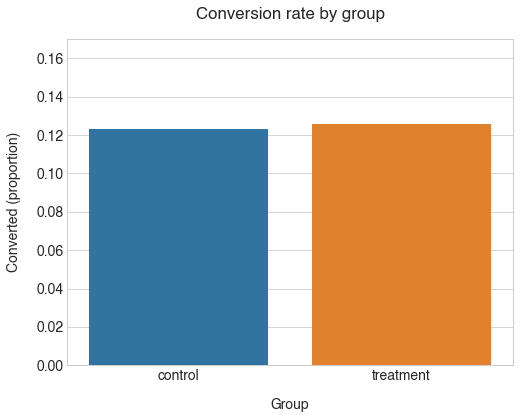

In [32]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

Коэффициенты конверсии для наших групп действительно очень близки. Также обратите внимание, что коэффициент конверсии контрольной группы ниже, чем то, что мы ожидали исходя из знаний о нашем среднем коэффициенте конверсии (12,3% против 13%). Это говорит о том, что есть некоторые различия в результатах при отборе выборки из совокупности.

Итак, значение группы `treatment` выше. **Является ли эта разница *статистически значимой***?

***
## 4. Тестирование гипотезы

Последний шаг нашего анализа - проверка нашей гипотезы. Поскольку у нас очень большая выборка, мы можем использовать <a href="https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Normal_approximation_interval"> нормальное приближение </a> для вычисления нашего значения $p$ (т. е. z-тест).

Опять же, Python упрощает все вычисления. Мы можем использовать модуль statsmodels.stats.proportion, чтобы получить значение $p$ и доверительные интервалы:

In [33]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [34]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [35]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'Доверительный интервал 95% для группы control: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'Доверительный интервал 95% для группы treatment: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
Доверительный интервал 95% для группы control: [0.114, 0.133]
Доверительный интервал 95% для группы treatment: [0.116, 0.135]


***
## 5. Выводы

Поскольку наше $p$ -значение=0.732 намного выше нашего $\alpha$ = 0.05, мы не можем отклонить нулевую гипотезу $H_0$, что означает, что наш новый дизайн не работал значительно (не говоря уже о лучшем), чем наш старый.

Кроме того, если мы посмотрим доверительный интервал для группы `treatment` ([0,116, 0,135], т.е. 11,6-13,5%), мы заметим, что:
1. Он включает наше базовое значение коэффициента конверсии 13%.
2. Он не включает наше целевое значение в 15% (рост на 2%, к которому мы стремились).

Это означает, что более вероятно, что истинный коэффициент конверсии нового дизайна будет похож на наш базовый уровень, а не на целевые 15%, на которые мы надеялись. Это еще одно доказательство того, что наш новый дизайн вряд ли станет улучшением нашего старого. Значит нужно придумать что-нибудь другое :)